In [12]:
# !pip install torch torchvision matplotlib pandas scikit-learn

In [13]:
#!/bin/bash
# !kaggle datasets download paultimothymooney/chest-xray-pneumonia

In [14]:
import zipfile
import os

# Specify the path to the zip file
zip_file_path = 'chest-xray-pneumonia.zip'
extract_to_path = '.'

# Create the directory if it doesn't exist
os.makedirs(extract_to_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Files extracted to {extract_to_path}")

Files extracted to .


In [15]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import os

In [16]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import os

# Directory paths for the dataset
train_data_dir = 'chest_xray/train'
test_data_dir = 'chest_xray/test'
val_data_dir = 'chest_xray/val'

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Preprocessing: Resize, Normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3), 
    transforms.ToTensor(),
    transforms.transforms.Normalize(
                    mean=[-m / s for m, s in zip(imagenet_mean, imagenet_std)],
                    std=[1 / s for s in imagenet_std]
                ) 
])


val_dataset = datasets.ImageFolder(root=val_data_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=transform)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [17]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

augmented_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.transforms.Normalize(
                    mean=[-m / s for m, s in zip(imagenet_mean, imagenet_std)],
                    std=[1 / s for s in imagenet_std]
                )  # ImageNet stats
])

# Apply augmentation only to the training dataset
train_augmented_data = datasets.ImageFolder(root=train_data_dir, transform=augmented_transform)
train_augmented_loader = DataLoader(train_augmented_data, batch_size=16, shuffle=True)


In [18]:
images, labels = next(iter(train_augmented_loader))
print(f"Image tensor shape: {images.shape}")  # e.g., [32, 3, 224, 224]
print(f"Pixel value range: {images.min()} to {images.max()}")  # Should show 0.0 to 1.0

Image tensor shape: torch.Size([16, 3, 224, 224])
Pixel value range: 0.4059999883174896 to 0.7122039198875427


In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class PneumoniaNN(nn.Module):
    """
    Improved CNN for melanoma classification with advanced features.
    - More convolutional layers and increased filter sizes.
    - Use of pretrained layers (transfer learning).
    - Learning rate scheduler support.
    """

    def __init__(self, pretrained=False, input_size=(3, 224, 224)):
        """Initialize the network layers."""
        super().__init__()

        # Pretrained layers (using a part of a ResNet or VGG model)
        if pretrained:
            # For example, you can load ResNet18 pretrained on ImageNet
            self.resnet = models.resnet18(pretrained=True)
            self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 2)  
        else:
            # Convolutional layers with Batch Normalization
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
            self.bn1 = nn.BatchNorm2d(64)
            self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm2d(128)
            self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
            self.bn3 = nn.BatchNorm2d(256)
            self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
            self.bn4 = nn.BatchNorm2d(512)
            
            # Residual connections
            self.skip1 = nn.Conv2d(64, 128, kernel_size=1)
            self.skip2 = nn.Conv2d(128, 256, kernel_size=1)
            
            self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

           
            
            # Improved fully connected layers
            self.fc1 = nn.Linear(512, 1024)
            self.dropout1 = nn.Dropout(0.3)
            self.fc2 = nn.Linear(1024, 512)
            self.dropout2 = nn.Dropout(0.3)
            self.fc3 = nn.Linear(512, 2)

            

    def forward(self, x):
        if hasattr(self, 'resnet'):
            return self.resnet(x)
            
        # Block 1
        identity1 = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        # Block 2 with skip connection
        identity2 = self.skip1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x + identity2, kernel_size=2)
        
        # Block 3 with skip connection
        identity3 = self.skip2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x + identity3, kernel_size=2)
        
        # Block 4
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        # FC layers
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x # Raw logits (no softmax, use CrossEntropyLoss during training)

    def get_feature_dims(self, input_size=(1, 224, 224)):
        """
        Calculate feature dimensions at each layer for debugging.

        Args:
            input_size (tuple): Input dimensions (channels, height, width)

        Returns:
            dict: Dictionary containing feature dimensions at each layer
        """
        dims = {}
        x = torch.zeros(1, *input_size)  # Create dummy input

        # Conv1
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), (2, 2))
        dims['conv1'] = x.shape

        # Conv2
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), (2, 2))
        dims['conv2'] = x.shape

        # Conv3
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), (2, 2))
        dims['conv3'] = x.shape

        # Global Average Pooling
        x = self.global_pool(x)
        dims['global_pool'] = x.shape

        # Flattened
        dims['flatten'] = x.view(x.size(0), -1).shape

        return dims


In [20]:
# Move model to GPU if available
import torch

try:
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()  # Automatically detects TPU if available
except ImportError:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [30]:
import torch.optim as optim

def train(model, num_epochs, learning_rate):

    # Loss function (Binary Cross-Entropy for binary classification)
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer (Adam)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        model.train().to(device)
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
    
        for inputs, labels in train_augmented_loader:  # Use train_augmented_loader for augmented data
            inputs, labels = inputs.to(device), labels.to(device)
    
            # Zero the parameter gradients
            optimizer.zero_grad()
    
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
    
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
    
            # Track accuracy
            _, predicted = torch.max(outputs, 1)
            total_preds += labels.size(0)
            correct_preds += (predicted == labels).sum().item()
    
            running_loss += loss.item()
    
        epoch_loss = running_loss / len(train_augmented_loader)
        epoch_accuracy = 100 * correct_preds / total_preds
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

In [33]:

net_pne = PneumoniaNN()
epochs = 10
learning_rate = 0.001
train(net_pne, epochs, learning_rate)

Epoch 1/10, Loss: 0.4247, Accuracy: 80.67%


KeyboardInterrupt: 

In [14]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            
            x = x.to(device)
            model = model.to(device)
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y.to(device)).sum() 
            num_samples += predictions.size(0)
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Check accuracy for pre-train model')
check_accuracy(train_augmented_loader, model)
check_accuracy(test_loader, model)
print('Check accuracy for Custom model')
check_accuracy(train_augmented_loader, net)
check_accuracy(test_loader, net)


Check accuracy for pre-train model
Got 4728 / 5216 with accuracy 90.64
Got 541 / 624 with accuracy 86.70
Check accuracy for Custom model
Got 4560 / 5216 with accuracy 87.42
Got 473 / 624 with accuracy 75.80


In [15]:
test_dir='/kaggle/working/chest_xray/test/NORMAL'
from skimage.io import imread
from PIL import Image
import glob
image_list = []
for filename in glob.glob(test_dir+'/*.jpeg'):
    #im=Image.open(filename)
    image_list.append(filename)

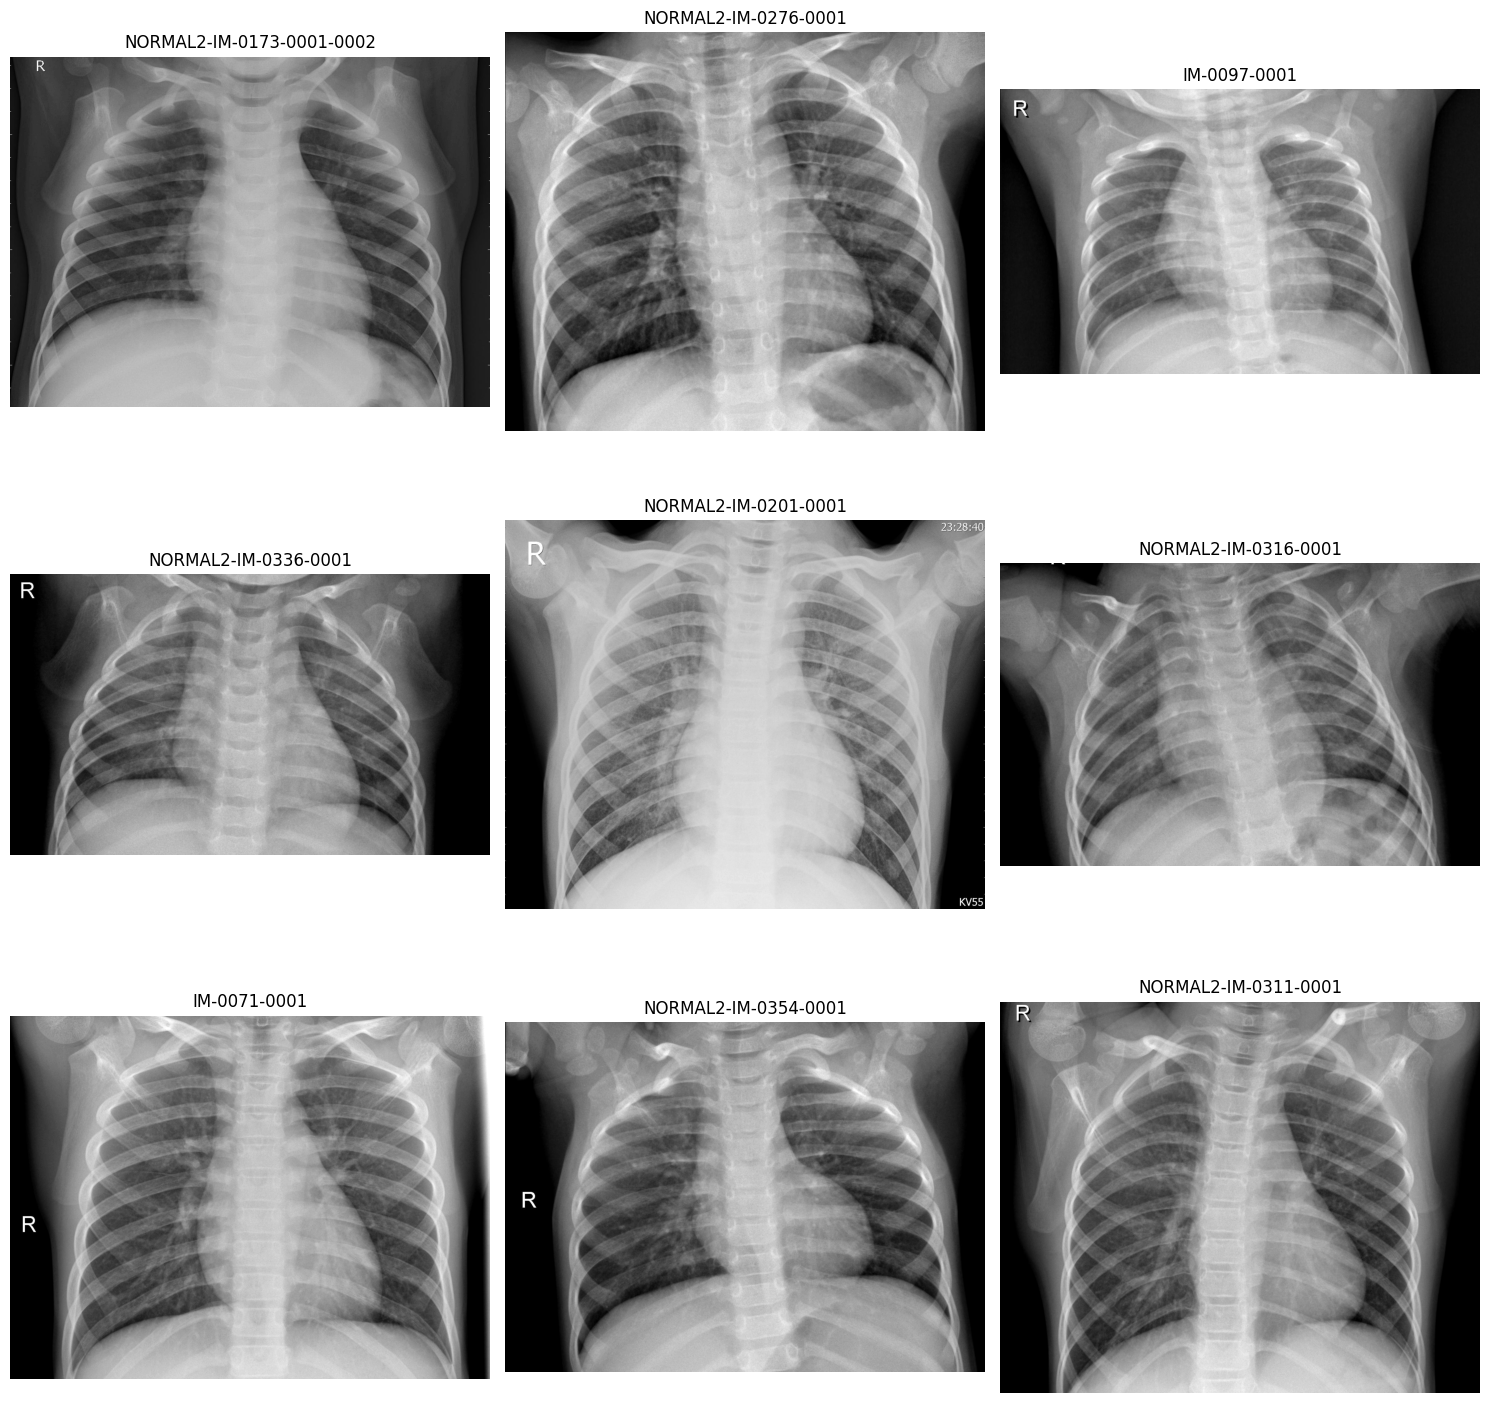

In [16]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import math

def plot_input(image_list):
    num_images = len(image_list)
    grid_size = math.ceil(math.sqrt(num_images))  # Determine grid size dynamically
    fig, ax = plt.subplots(grid_size, grid_size, figsize=(15, 15))  # Adjust figure size
    ax = ax.flatten()  # Flatten the axes array for easy indexing

    for i in range(len(image_list)):
        img = imread(image_list[i])
        name = image_list[i].split("/")[-1].split(".")[0]
        ax[i].imshow(img, cmap='gray')  # Show the image
        ax[i].set_title(name, fontsize=12)  # Set the title for each image
        ax[i].axis('off')  # Hide axes for a cleaner look

    # Hide unused subplots (if any)
    for i in range(len(image_list), len(ax)):
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
plot_input(image_list[:9])


In [17]:
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        # Forward pass
        self.model.eval()
        output = self.model(x)

        if class_idx is None:
            class_idx = output.argmax(dim=1)

        # Zero gradients
        self.model.zero_grad()

        # Target for backprop
        one_hot = torch.zeros_like(output)
        one_hot[0][class_idx] = 1

        # Backward pass
        output.backward(gradient=one_hot, retain_graph=True)

        # Global average pooling of gradients
        weights = torch.mean(self.gradients, dim=(2, 3))

        # Weight the activations
        cam = torch.zeros(self.activations.shape[2:], device=self.activations.device)
        for i, w in enumerate(weights[0]):
            cam += w * self.activations[0, i]

        # Apply ReLU and normalize
        cam = F.relu(cam)
        cam = cam - torch.min(cam)
        cam = cam / torch.max(cam)

        return cam.detach()

def visualize_cam(image, cam):
    # Convert PIL Image to numpy array
    if isinstance(image, Image.Image):
        image_np = np.array(image)
    else:
        image_np = image

    # Convert CAM to numpy array if it isn't already
    if torch.is_tensor(cam):
        cam = cam.cpu().numpy()

    # Normalize CAM to 0-1 range if needed
    if cam.max() > 1:
        cam = (cam - cam.min()) / (cam.max() - cam.min())

    # Ensure cam is the same size as the input image
    cam_resized = cv2.resize(cam, (image_np.shape[1], image_np.shape[0]))

    # Create heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)

    # Convert RGB to BGR if necessary (OpenCV uses BGR)
    if len(image_np.shape) == 3 and image_np.shape[2] == 3:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    # Ensure both images have the same number of channels
    if len(image_np.shape) != len(heatmap.shape):
        if len(image_np.shape) == 2:
            image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2BGR)

    # Now combine them
    result = cv2.addWeighted(image_np, 0.7, heatmap, 0.7, 5)

    return result

In [19]:
import random

plt.figure(figsize=(15, 15))
num_samples = 5
random_img_paths = random.sample(image_list, num_samples)

for idx, path in enumerate(random_img_paths):
    # Load and preprocess image
    pil_image = Image.open(path).convert('RGB')


    # Define transforms

    transform = transforms.Compose([
            transforms.Resize(224),
            transforms.Grayscale(num_output_channels=3),  
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
    ])

    # Transform and add batch dimension

    input_tensor = transform(pil_image).unsqueeze(0)

    # Move everything to GPU if available

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    target_layer = model.layer4[2].conv3
    grad_cam = GradCAM(model, target_layer)
    input_tensor = input_tensor.to(device)
    # Generate CAM
    cam = grad_cam(input_tensor)
    # Visualize
    input_image = transforms.ToPILImage()(input_tensor.squeeze(0).cpu())
    result = visualize_cam(input_image, cam)

     # Plot original and Grad-CAM
    plt.subplot(num_samples, 2, 2*idx + 1)
    plt.imshow(pil_image)
    plt.title(f'Original -')
    plt.axis('off')

    plt.subplot(num_samples, 2, 2*idx + 2)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title('Grad-CAM')
    plt.axis('off')

plt.tight_layout()
plt.show()


AttributeError: 'MobileNetV2' object has no attribute 'layer4'

<Figure size 1500x1500 with 0 Axes>

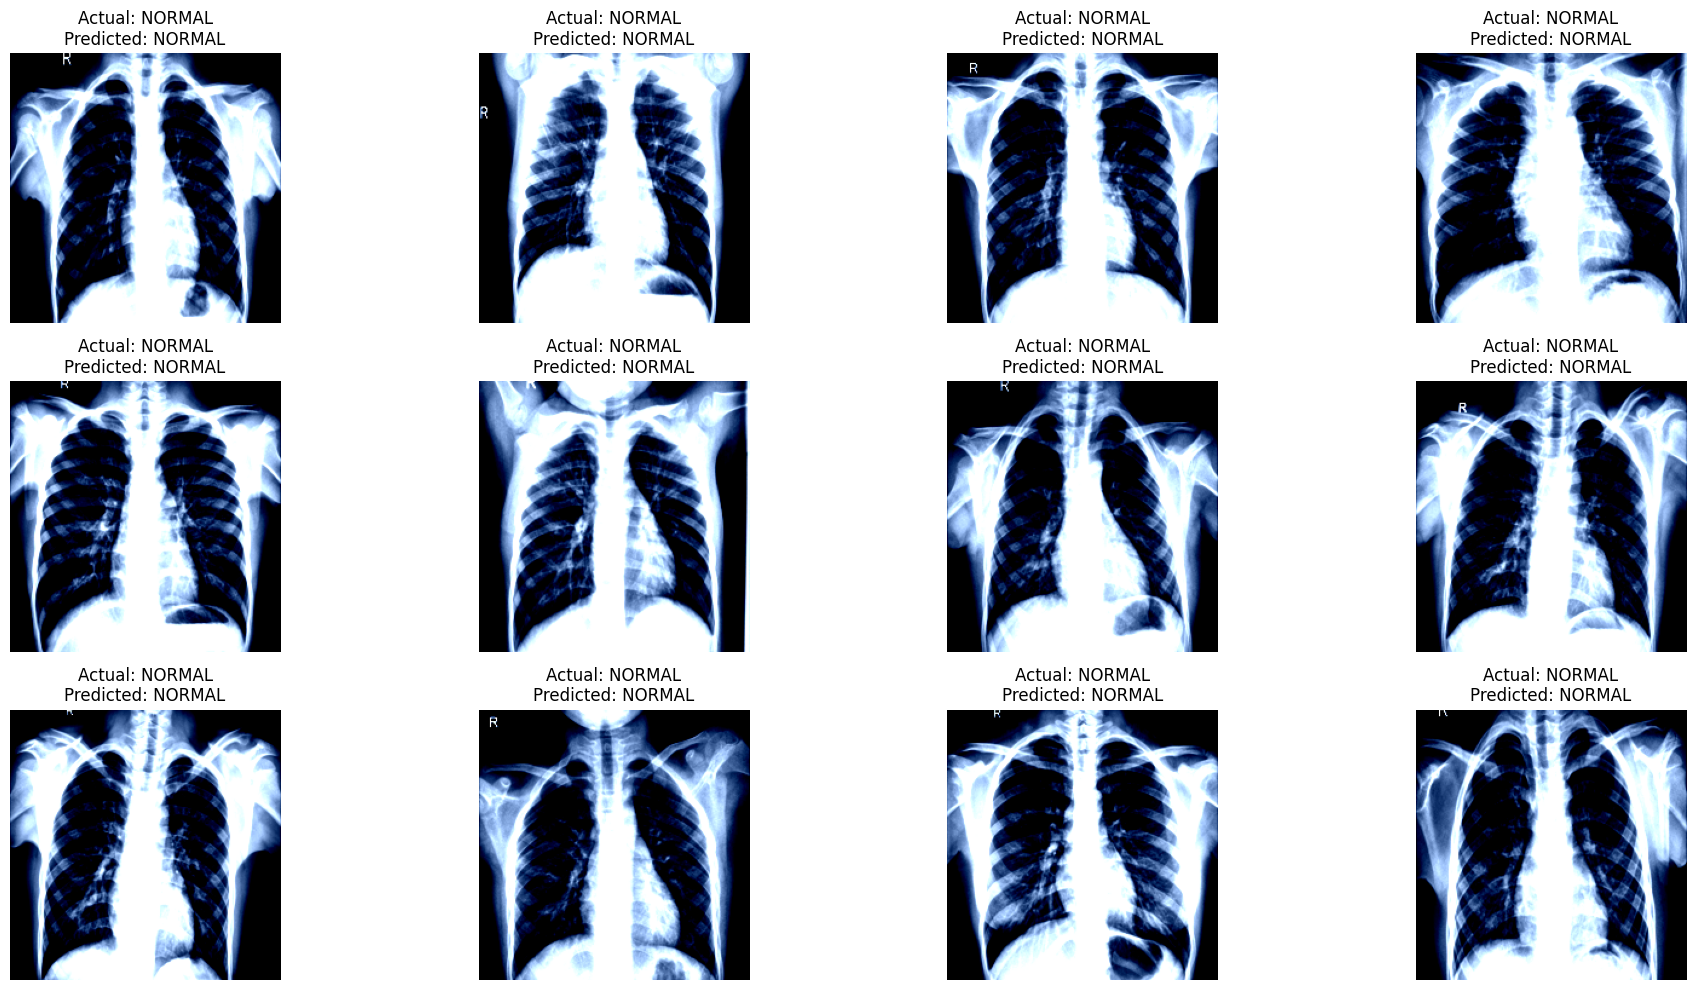

In [29]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

def visualize_predictions_from_loader(val_loader, model, class_names, transform=None):
    """
    Predict and display the first 8 images from the validation loader with their predicted and actual labels.

    Args:
        val_loader (DataLoader): DataLoader for validation dataset.
        model (torch.nn.Module): Trained PyTorch model for prediction.
        class_names (list): List of class names corresponding to class indices.
        transform (callable): Transformations to apply to the images before prediction.
    """
    # Create a grid for visualization
    fig, ax = plt.subplots(3, 4, figsize=(20, 10))  # 2 rows, 4 columns
    ax = ax.flatten()

    # Ensure the model is in evaluation mode
    model.eval()

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Get the first batch of data from the validation loader
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            if i == 0:  # Only take the first batch
                break

        # Make sure we only use the first 8 images
        images = images[:12]
        labels = labels[:12]

        # Send the images and labels to the same device as the model
        images, labels = images.to(device), labels.to(device)

        # Make predictions
        outputs = model(images)
        _, predicted_labels = torch.max(outputs, 1)

        # Convert tensors to CPU and numpy for display
        images = images.cpu()
        predicted_labels = predicted_labels.cpu()
        labels = labels.cpu()

        # Display the images with actual and predicted labels
        for i in range(12):
            img = images[i].cpu().numpy().transpose((1, 2, 0))  # Convert to HWC format
            ax[i].imshow(img)
            ax[i].axis('off')  # Hide axes for a cleaner look
            ax[i].set_title(
                f"Actual: {class_names[labels[i]]}\nPredicted: {class_names[predicted_labels[i]]}",
                fontsize=12
            )

    plt.tight_layout()
    plt.show()

# Example usage
class_names = ['NORMAL', 'PNEUMONIA']

# Assuming `val_loader` is your validation data loader
visualize_predictions_from_loader(test_loader, net, class_names)


In [27]:
import torch
from sklearn.metrics import confusion_matrix

def confusion_matrix(loader, model):
    test_labels = []
    predicted_labels = []  # Initialize a list to store predictions
      
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())
    
    # Calculate confusion matrix using predicted labels
    conf_mat = confusion_matrix(test_labels, predicted_labels)
    return conf_mat


cm_pre_tra = confusion_matrix(test_loader, model)


TypeError: cannot unpack non-iterable numpy.int64 object

In [24]:
cm_custom = confusion_matrix(test_loader, net)

AttributeError: 'list' object has no attribute 'eval'

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.0f' #if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


plot_confusion_matrix(cm_pre_tra, classes=['NORMAL', 'PNEUMONIA'], title='Confusion Matrix for pre_train')
plot_confusion_matrix(cm_custom, classes=['NORMAL', 'PNEUMONIA'], title='Confusion Matrix for Custom CNN')


In [ ]:
from torchviz import make_dot
from torchsummary import summary

def archit(model):
    summary(model, (3, 224, 224))
    dummy_input = torch.randn(16, 3, 224, 224).to(device) 
    
    output = net(dummy_input).to(device)
    
    dot = make_dot(output, params=dict(net.named_parameters()))
    
    dot.render("model_architecture1", format="png") 
    dot.view()

archit(net)
archit(model)